# <center><h2>Whether Classification Using CNN </h2></center>

## Problem Statement :
Weather plays a significant role in various industries, including agriculture, aviation, and outdoor event planning. Accurate weather classification helps in understanding weather patterns and making informed decisions. This task involves classifying weather images into four different categories:

1. Cloudy,
2. Rain,
3. Shiny,
4. Sunrise.

The process involves several steps, including importing libraries, loading and viewing data, splitting the data into training and validation sets, data pre-processing, building the CNN model, training the model, and analyzing the model's performance.

**Step 1:** Importing Libraries and Data: In this step, we import the necessary libraries such as Pandas, NumPy, and TensorFlow. We also load the weather images from the dataset directory using tf.keras.preprocessing.image_dataset_from_directory. This function automatically loads the images from the directory and creates an image dataset along with their corresponding labels.

**Step 2:** Viewing Data Images: We visualize and inspect a few samples of the loaded data to ensure that the images are correctly loaded and to understand the structure of the dataset.

**Step 3:** Splitting the Data: We split the dataset into training and validation sets. The training set is used to train the CNN model, while the validation set is used to evaluate the model's performance on unseen data.

**Step 4:** Data Pre-processing: Data pre-processing involves several steps to prepare the images for training. These steps include resizing and rescaling the images to a consistent size, data augmentation to increase the dataset's diversity and generalization, and other normalization techniques.

**Step 5:** Model Building: In this step, we build the CNN model using TensorFlow's Keras API. The model consists of Convolutional layers (Conv2D), MaxPooling layers to reduce the spatial dimensions, and other necessary layers. We optimize the model using the Adam optimizer and use Sparse Categorical Crossentropy as the loss function, as we have multiple classes and integer-encoded labels. We also define accuracy metrics to monitor the model's performance during training.

**Step 6:** Model Training and Analysis: We train the CNN model on the training set and evaluate its performance on the validation set. During training, we monitor metrics such as training accuracy, validation accuracy, training loss, and validation loss to analyze the model's behavior and identify potential overfitting.

**Step 7:** Predicting on New Images (Unknown Weather): Finally, we plot and analyze images from a new directory called "Unknown Weather," which contains weather images downloaded from the internet. We use the trained CNN model to predict the class (Cloudy, Rain, Shiny, or Sunrise) of each unknown weather image.

## Step 1 : Importing Libraries and Data

import sys
!{sys.executable} -m pip install tensorflow
import tensorflow as tf
print(tf.__version__)

In [8]:
# importing libraries
import numpy as np # for linear algebra
import pandas as pd # data preprocessing

import tensorflow as tf # deep learning
from tensorflow.keras import layers, models # working on layers
import matplotlib.pyplot as plt # data visualization

In [9]:
# setting image_size and batch_size
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [10]:
# importing dataset directory 
df = tf.keras.preprocessing.image_dataset_from_directory("weather_classification",shuffle=True,image_size= (IMAGE_SIZE,IMAGE_SIZE),
                                                        batch_size= BATCH_SIZE)

Found 1126 files belonging to 4 classes.


In [11]:
# getting class names
class_names = df.class_names
class_names

['Cloudy', 'Rain', 'Shiny', 'Sunrise']

In [16]:
# len of dataset ( Total number of files/ batch size)
len(df)

36

In [18]:
36*32 #1152, but number of files are 1125 only

1152

In [20]:
print(df)  # None is the undefined batch size, (256,256) is the image size and 3 = channels(RGB)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## Step 2 : Viewing Data Images

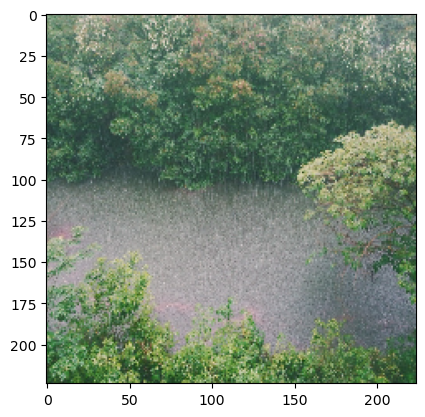

In [23]:
# viewing image 
for image_batch, label_batch in df.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    
    # plt.axis("off") : used to view image without axis points
# refreshing every time gives another picture and label as given

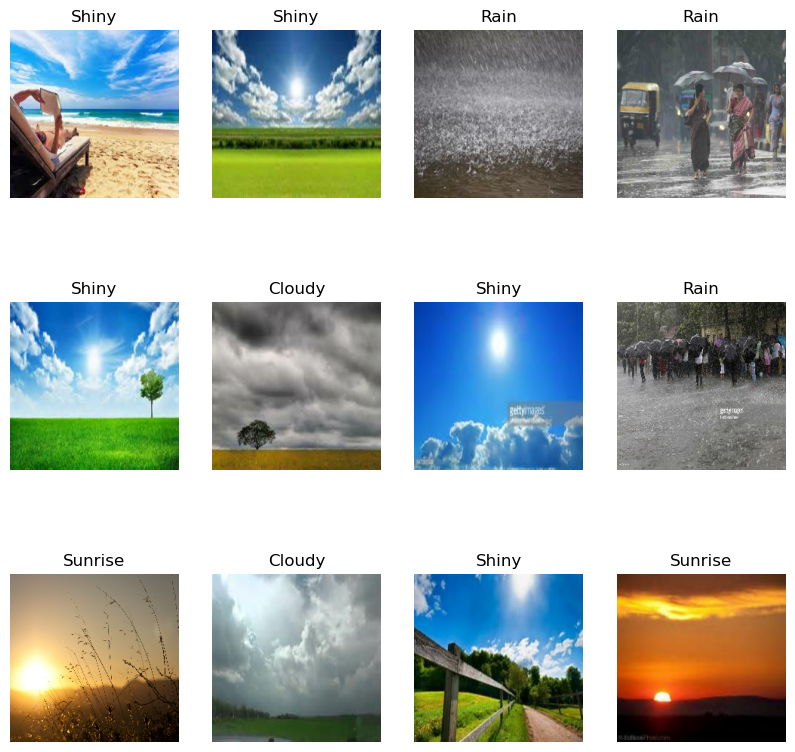

In [25]:
# images with the labels
plt.figure(figsize=(10,10))
for image_batch, label_batch in df.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
        
# refreshing every time gives another picture and label as given

## Step 3 : Splitting Dataset

### 80% --> Training
### 20% --> 10% Validation and 10% Testing

In [29]:
# channels (RGB[Red, Green, Blue]), Epochs = 50
CHANNELS = 3
EPOCHS = 50

In [31]:
# checking the length of training data
train_size = 0.8
len(df) * train_size

28.8

In [33]:
# length of validation and test data
val_n_test = len(df) - (len(df) * train_size)
val_n_test

7.199999999999999

In [35]:
# splitting the data into training , validation and testing data

def split_datasets(pc,train_split = 0.8,val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    if shuffle:
        pc = pc.shuffle(shuffle_size,seed = 10)
        
    pc_size = len(pc) # size of weather_data(36)
    train_size = int(train_split*pc_size)
    val_size = int(val_split*pc_size)
    
    train_pc = pc.take(train_size) # taking first 28 batches(out of 36)
    val_pc = pc.skip(train_size).take(val_size) # leaving first 28 and taking next 8 batches
    test_pc = pc.skip(train_size).skip(val_size) # skipping first 28(train) batch and 4(validation) batch and 
                                                 #taking left 4 batches for test
    
    return train_pc, val_pc, test_pc

In [37]:
# getting the training, validation and testing data by 'split_datasets' function
train_data, val_data, test_data = split_datasets(df)

In [40]:
# printing the size of all data splits
print("Size of Data is :{0} \nBatch Size of Training Data is :{1} \nBatch Size of Validation Data :{2} \nBatch Size of Test Data :{3}"
      .format(len(df), len(train_data), len(val_data), len(test_data)))

Size of Data is :36 
Batch Size of Training Data is :28 
Batch Size of Validation Data :3 
Batch Size of Test Data :5


In [62]:
# caching, shuffling and prefetching the data
train_pc = train_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_pc = val_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_pc = test_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

## Step 4 : Data Pre-Processing 

In [65]:
# Image Preprocessing: Rescaling and Resizing
rescale_n_resize = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

# Data Augmentation by flipping and rotating existing images
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical'),
    layers.RandomRotation(factor=0.5)
])


## Step 5 : Model Building

In [68]:
# Creating CNN
model = models.Sequential([
    rescale_n_resize,
    data_augmentation,
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='softmax')
])



In [79]:
# model_summary
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 109, 109, 64)   │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 24, 24, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 3, 3, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 964,802 (3.68 MB)

 Trainable params: 321,600 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 643,202 (2.45 MB)

In [72]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Adjust based on your target data
              metrics=['accuracy'])

In [74]:
# optimizing the model
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

## Step 6 : Model Training and Analysis

In [77]:
# fitting the model
history = model.fit(train_data, epochs = EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, verbose=1)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 703ms/step - accuracy: 0.2258 - loss: 2.6053 - val_accuracy: 0.4271 - val_loss: 1.2799
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 580ms/step - accuracy: 0.4926 - loss: 1.0899 - val_accuracy: 0.7188 - val_loss: 0.6775
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 657ms/step - accuracy: 0.6523 - loss: 0.8002 - val_accuracy: 0.7500 - val_loss: 0.7214
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 614ms/step - accuracy: 0.6958 - loss: 0.6879 - val_accuracy: 0.7083 - val_loss: 0.7364
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 615ms/step - accuracy: 0.6994 - loss: 0.6653 - val_accuracy: 0.7292 - val_loss: 0.5935
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 572ms/step - accuracy: 0.6841 - loss: 0.6303 - val_accuracy: 0.6979 - val_loss: 0.5646
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 573ms/step - accuracy: 0.7445 - loss: 0.5981 - val_accuracy: 0.7292 - val_loss: 0.5387
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 626ms/step - accuracy: 0.7576 - loss: 0.5799 - val_accu

In [82]:
# evaluating the scores
scores = model.evaluate(train_data)
scores

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.9065 - loss: 0.2664


[0.2604271471500397, 0.9091954231262207]

In [84]:
# getting the keys of fitted model "History"
history.params, history.history.keys()

({'verbose': 1, 'epochs': 50, 'steps': 28},
 dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss']))

In [88]:
# assigning names to the keys
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

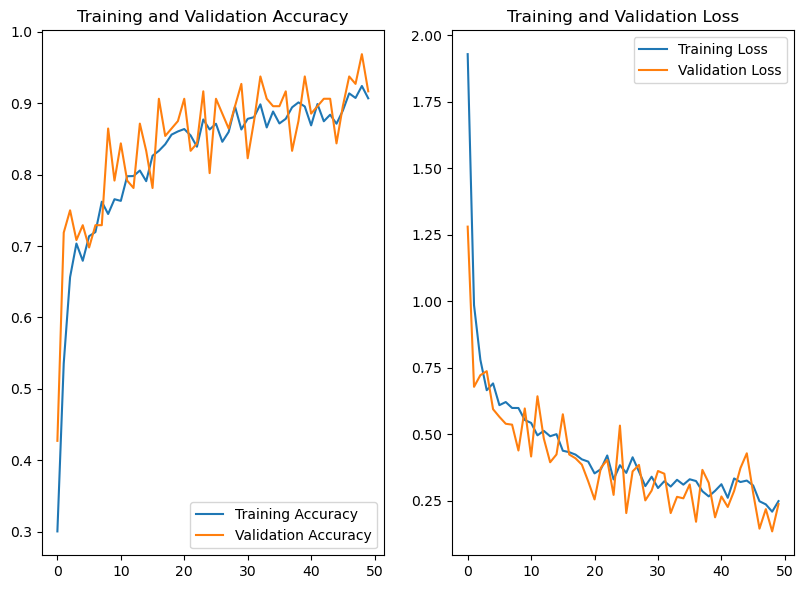

In [90]:
# plotting the comparison graphs
plt.figure(figsize = (15,15))

# Accuracy Table
plt.subplot(2,3,1)
plt.plot(range(EPOCHS),train_acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Table
plt.subplot(2,3,2)
plt.plot(range(EPOCHS),train_loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

## Validation on Test Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


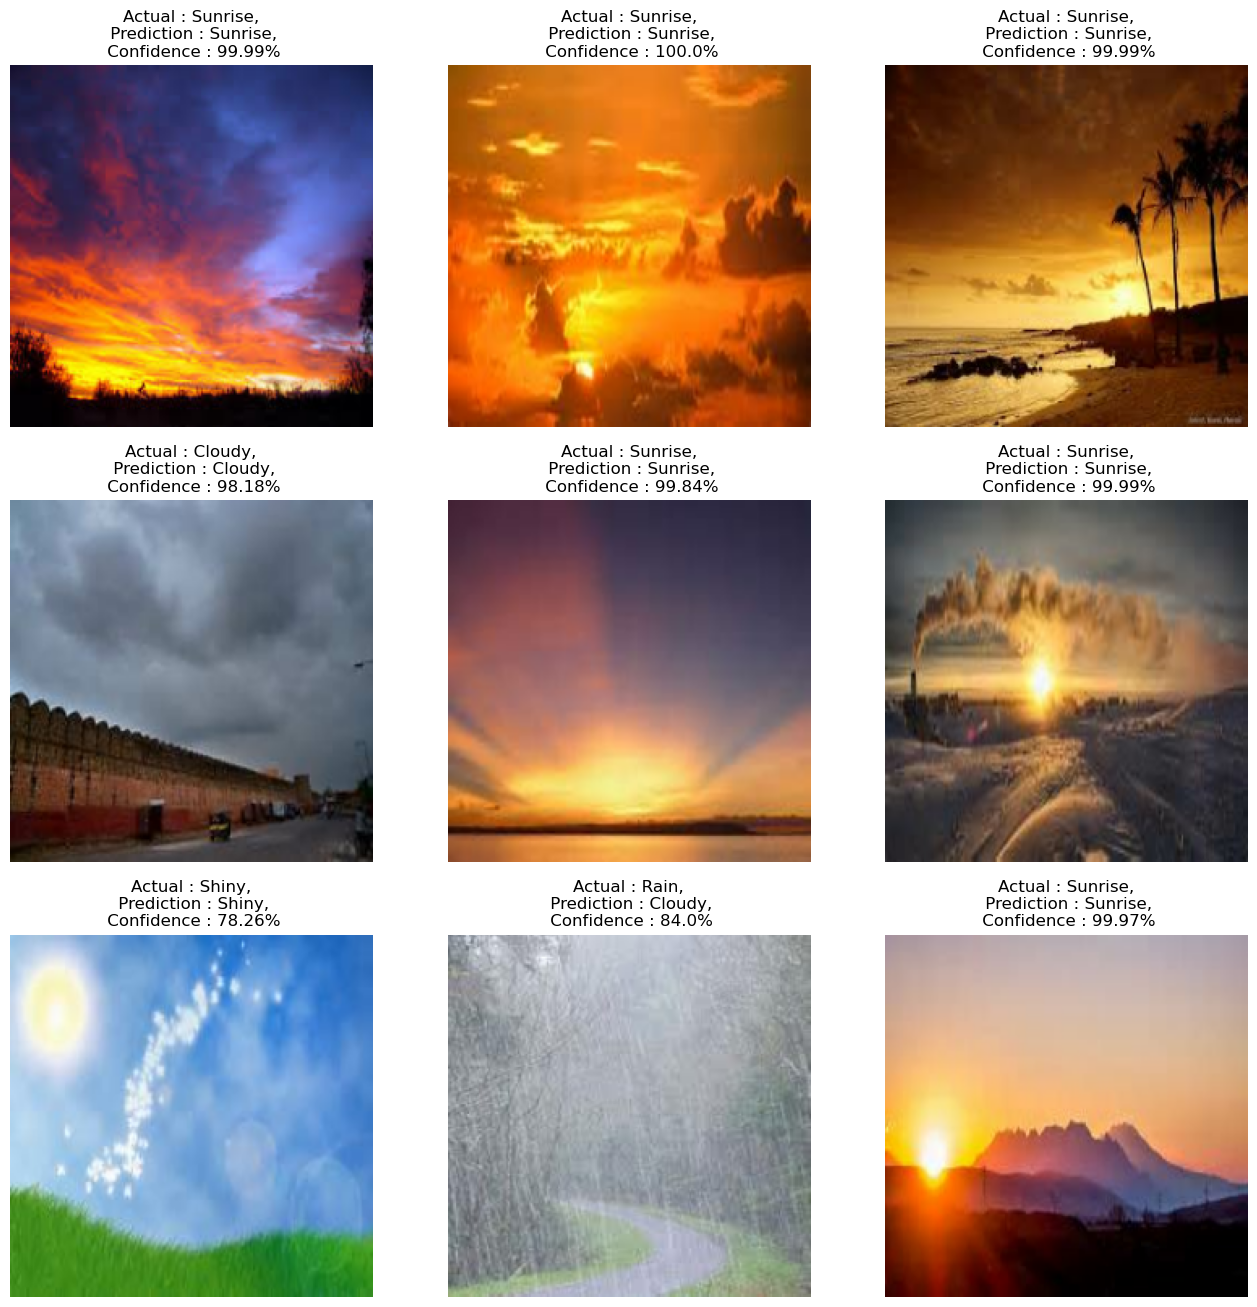

In [92]:
# plotting batch of test images with its actual label, predicted label and confidence
plt.figure(figsize = (16,16))
for batch_image, batch_label in test_pc.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_names[batch_label[i]]
    
        plt.imshow(image)
    
        batch_prediction = model.predict(batch_image)
        predicted_class = class_names[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')
    
        plt.axis('off')

## Step 7 : Predicting on New Images

In [125]:
# importing new dataset for new predictions
unk_lf = tf.keras.preprocessing.image_dataset_from_directory("New_images",image_size=(IMAGE_SIZE,IMAGE_SIZE))

Found 9 files belonging to 1 classes.


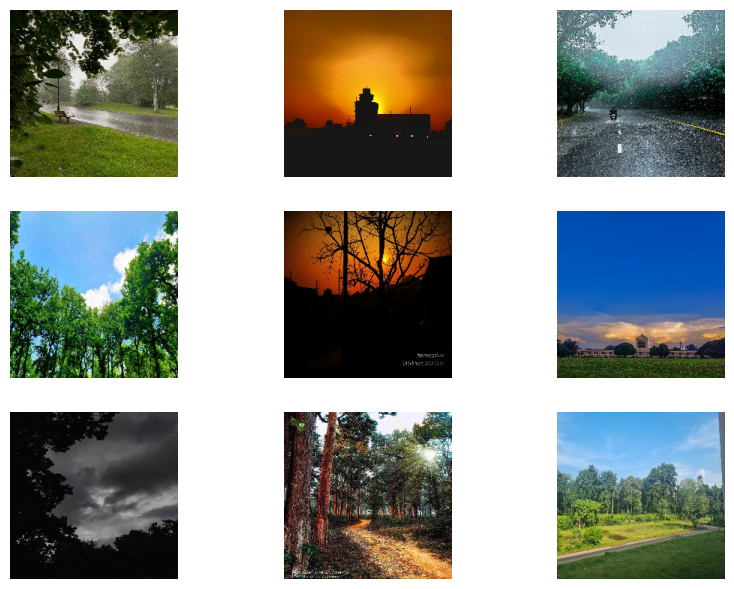

In [127]:
for image_batch, label_batch in unk_lf.take(2):
    total_images = image_batch.shape[0]  # Get the total number of images in the batch
    plt.figure(figsize=(10, 10))  # Adjust the figure size if needed
    for i in range(9):
        plt.subplot((9 // 3) + 1, 3, i + 1)  # Adjust the grid size dynamically
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


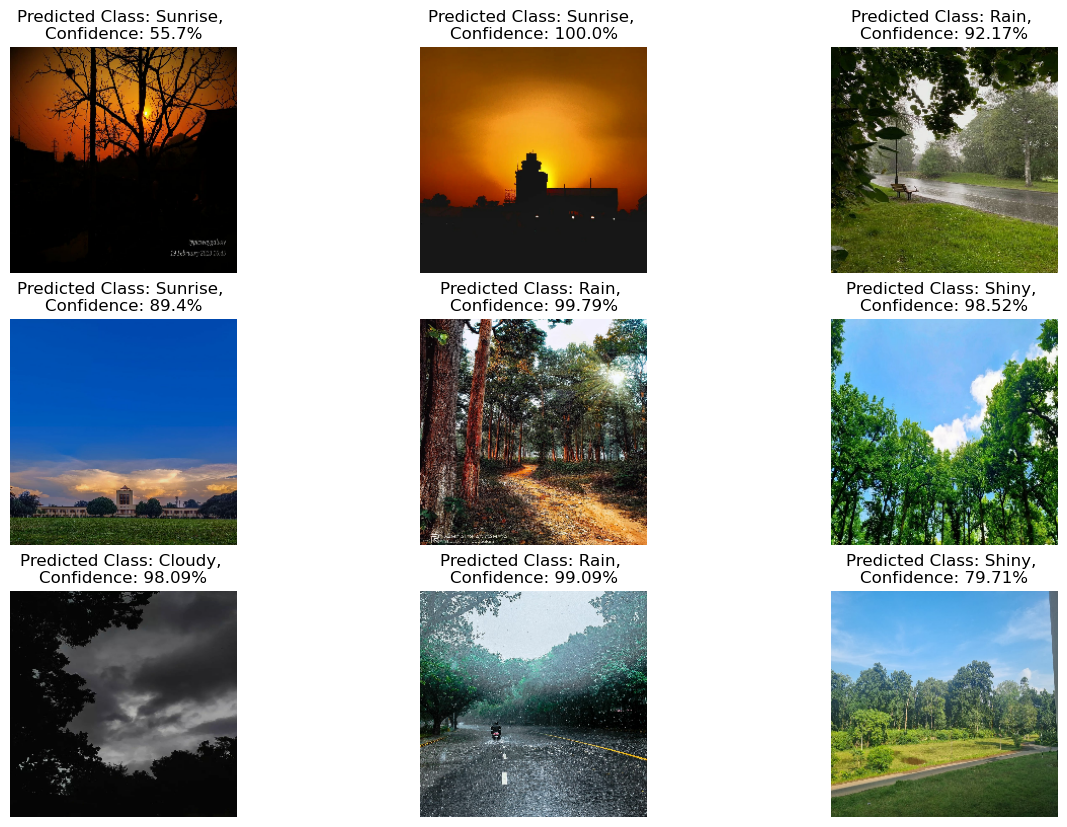

In [129]:
plt.figure(figsize=(15, 10))
for image_batch, label_batch in unk_lf.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)  # Changed to a 3x3 grid
        image = image_batch[i].numpy().astype("uint8")
        label = class_names[label_batch[i]]
        
        plt.imshow(image)
        
        # Predict the class
        unk_lf_pred = model.predict(image_batch)
        pred_class = class_names[np.argmax(unk_lf_pred[i])]
        confidence = round(np.max(unk_lf_pred[i]) * 100, 2)
        
        plt.title(f'Predicted Class: {pred_class}, \nConfidence: {confidence}%')
        plt.axis("off")

plt.show()


# <center><h1> Thank You! </h1></center>